In [1]:
import pandas as pd
from scipy import sparse
import numpy as np

Based on dataset description we can predict, for instance, will use tag bookmark or not

In [2]:
ds = pd.read_table('user_taggedbookmarks.dat')
ds.head()

C:\Users\i307747\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,userID,bookmarkID,tagID,day,month,year,hour,minute,second
0,8,1,1,8,11,2010,23,29,22
1,8,2,1,8,11,2010,23,25,59
2,8,7,1,8,11,2010,18,55,1
3,8,7,6,8,11,2010,18,55,1
4,8,7,7,8,11,2010,18,55,1


In [3]:
import matplotlib.pyplot as plt
ds.groupby('userID')['tagID'].count().hist()
plt.show()

<Figure size 640x480 with 1 Axes>

From dataset we can see that users are mostly tending to tag few bookmarks, which is quite expected behaivior

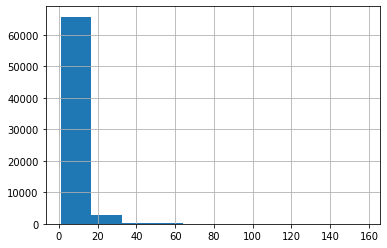

In [4]:
ds.groupby('bookmarkID')['tagID'].count().hist()
plt.show()

Same observation applies to urls, but here distribution is even more shifted to 0

In [5]:
uds = ds[['userID','bookmarkID']]
#ignoring tags, we are just interested in the fact that tag was set

In [6]:
uds['tagged'] = 100
uds.head()

C:\Users\i307747\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,userID,bookmarkID,tagged
0,8,1,100
1,8,2,100
2,8,7,100
3,8,7,100
4,8,7,100


In [7]:
users = list(np.sort(uds.userID.unique()))
bookmarks = list(np.sort(uds.bookmarkID.unique()))
tags = list(uds.tagged)

In [8]:
rows = uds.userID.astype(int)
cols = uds.bookmarkID.astype(int)

In [9]:
data_sparse = sparse.csr_matrix((tags, (cols, rows)), shape=(max(bookmarks)+1, max(users)+1))

In [10]:
from implicit.als import AlternatingLeastSquares

In [11]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

GPU training requires factor size to be a multiple of 32. Increasing factors from 50 to 64.
100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:01<00:00,  8.00it/s]


In [35]:
uid = np.random.choice(users)

user_items = data_sparse.T.tocsr()
wiil_tag = model.recommend(uid, user_items)
wiil_tag

[(3896, 0.9538642),
 (3925, 0.95200855),
 (3921, 0.9428152),
 (3922, 0.9410938),
 (3894, 0.92782426),
 (3929, 0.92507976),
 (3907, 0.91315114),
 (3918, 0.91168994),
 (3928, 0.9114908),
 (4034, 0.89822876)]

In [36]:
iid = np.random.choice(bookmarks)
similar_products = model.similar_items(iid)
similar_products

[(52836, 0.019768616),
 (52896, 0.019768614),
 (52893, 0.019768614),
 (52845, 0.019768612),
 (52839, 0.019768612),
 (52887, 0.01976861),
 (52879, 0.01976861),
 (52820, 0.01976861),
 (52849, 0.01976861),
 (52847, 0.019768609)]

With Implicit library we are getting easy to consume framework to build ALS models.

In [17]:
bm = pd.read_table('bookmarks.dat',encoding='koi8-r')

C:\Users\i307747\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [20]:
bm.drop(['md5','md5Principal','url'],axis=1,inplace=True)
bm.head()

,id,title,urlPrincipal
0,1,IFLA - The official website of the Internation...,www.ifla.org
1,2,gcdp-e.pdf (application/pdf Object),archive.ifla.org
2,7,EdSelect,www.edselect.com
3,8,Cool Canada (Collections Canada),www.collectionscanada.gc.ca
4,9,Kidsreads.com,www.kidsreads.com


In [32]:
from tqdm import tqdm_notebook

In [33]:
urls_dict = {}
for row in tqdm_notebook(bm.index):
    urls_dict[bm.iloc[row].id] = (bm.iloc[row].title,bm.iloc[row].urlPrincipal)

In [37]:
for tag in wiil_tag:
    print(urls_dict[tag[0]],tag[1])

('Lettering.JS | daverupert.com', 'daverupert.com') 0.9538642
('Fuel the Brain | A Lucky Place', 'www.fuelthebrain.com') 0.95200855
('Harcourt Stories activities', 'www.primarygradesclasspage.com') 0.9428152
('Illuminations: Welcome to Illuminations', 'illuminations.nctm.org') 0.9410938
('RVM: Ruby Version Manager - &#039;rvm package install readline&#039;', 'rvm.beginrescueend.com') 0.92782426
('ABCya! The Leader in Kids Educational Computer Games &amp; Activities', 'abcya.com') 0.92507976
('setlist.fm - the setlist wiki', 'www.setlist.fm') 0.91315114
('Periodic_Table_of_Typefaces_large.jpg (JPEG Image, 3150x2100 pixels)', 'www.squidspot.com') 0.91168994
('Math Tools', 'mathforum.org') 0.9114908
('CARL Book Beacon: Twitter can do WHAT with your photos?', 'www.comarmsblog.com') 0.89822876


In [38]:
for product in similar_products:
    print(urls_dict[product[0]],product[1])

('Best Android Applications | Most Useful Android Applications | Top Android Applications', 'techie-buzz.com') 0.019768616
('Breaking A Goal Into Metrics | Brand Elevation Through Social Media and Social Business | Altitude Branding', 'altitudebranding.com') 0.019768614
('iPhone UX Reviews', 'www.iphoneuxreviews.com') 0.019768614
('iMAndroid - All about Android News, Android Reviews, Android Rumors, Android Applications, Android Application Developers▓ Interviews', 'imandroid.org') 0.019768612
('Top 25 Android apps: The best of the best | ZDNet', 'www.zdnet.com') 0.019768612
('Nancy Duarte: How to Practice Smart &#039;Slide-ology&#039; - Business Resources &amp; Advice', 'features.bizmore.com') 0.01976861
('Twitter Lists', 'lists.tweetmeme.com') 0.01976861
('33 ways to make your app a hit: VentureBeatБ─≥s Discovery Directory | VentureBeat', 'venturebeat.com') 0.01976861
('Androinica', 'androinica.com') 0.01976861
('Google Android Applications &amp; G1 Phone Tips News &amp; Info | Googl

Looking quite relevant according to my analysis.